[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Dessia-tech/tutorials/blob/main/notebook/power_transmission.ipynb)

# Python imports

In [1]:
!pip install dessia_common
!pip install volmdlr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 9.6 MB/s eta 0:00:00
  Created wheel for dessia_common: filename=dessia_common-0.15.3-py3-none-any.whl size=164619 sha256=2e3426bd6a4635258d3302cb23ce04f05fc82ebba5b3cc63812681425ae27120
  Stored in directory: /root/.cache/pip/wheels/5d/cd/dd/4d72e95bc985b7ddd216e79ccb978c771a47d7128691e89019
  Created wheel for dectree: filename=dectree-0.1.0-py3-none-any.whl size=7480 sha256=2b2face477fa0a89dd33da32f463

In [3]:
import math
import numpy as npy
from scipy.optimize import minimize
from typing import List, Tuple
from IPython.display import HTML
from dessia_common.core import PhysicalObject, DessiaObject
import volmdlr as vm
import volmdlr.primitives3d as p3d

# Introduction

The goal of this tutorial is to understand how the optimization works in our modules and how to create an optimized bot. Let's take a simple case: the construction and optimization of a simple reductor made of 3 shafts, 4 gears and 1 motor.

In this example, we want to optimize the mass of this reductor that meets a couple specifications:

- The ratio between the input and the output speed is imposed
- The reductor must fit into a box that is imposed

The paramaters that the bot will optimize are the axial distances e1 and e2 and the diameter of each gear.

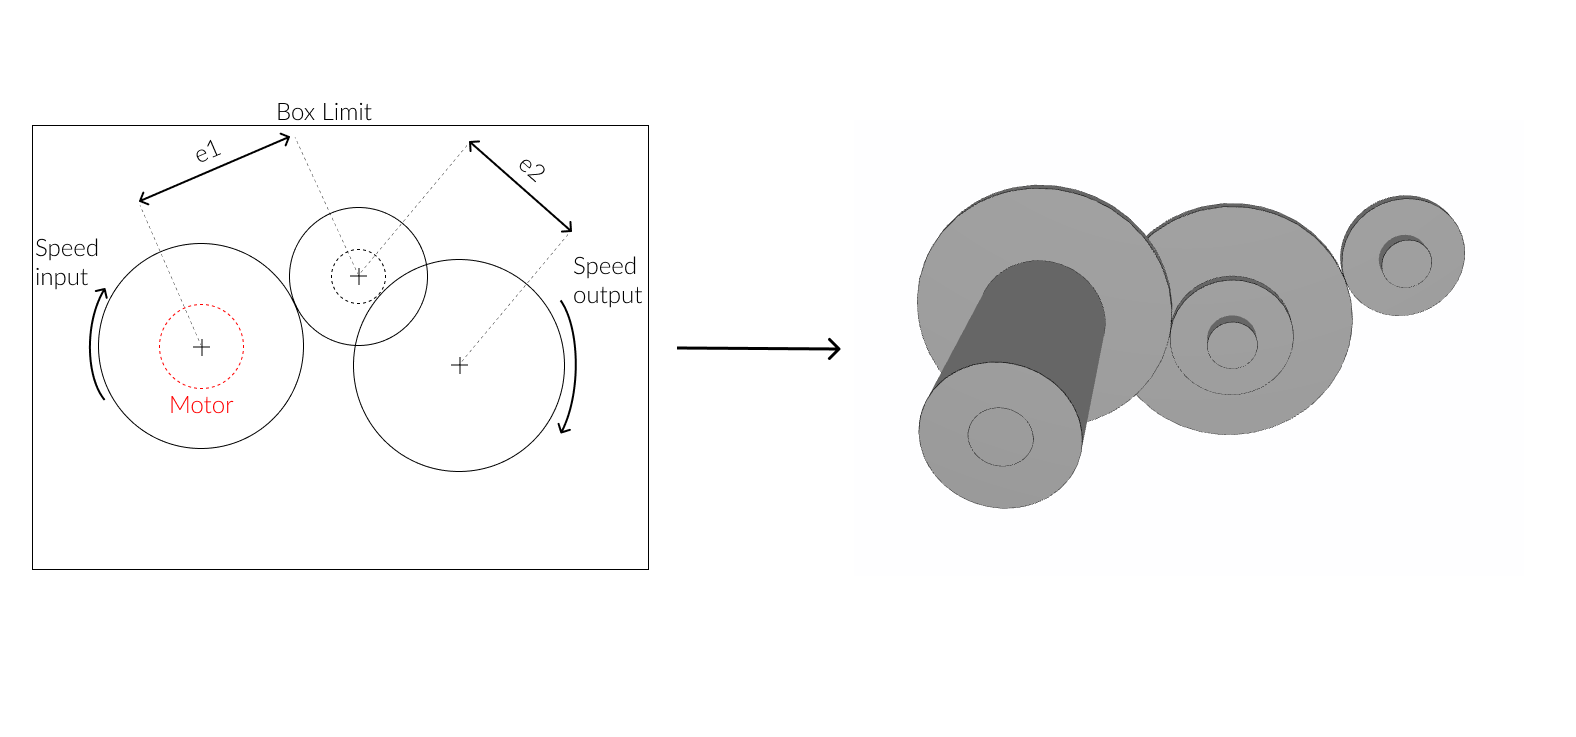

# Build the bot in 4 steps

The goal of this tutorial is to understand how the optimization works in our modules and how to create an optimized bot. Let's take a simple case: the construction and optimization of a simple reductor made of 3 shafts, 4 gears and 1 motor.

In this example, we want to optimize the mass of this reductor that meets a couple specifications:

- The ratio between the input and the output speed is imposed
- The reductor must fit into a box that is imposed

The paramaters that the bot will optimize are the axial distances e1 and e2 and the diameter of each gear.

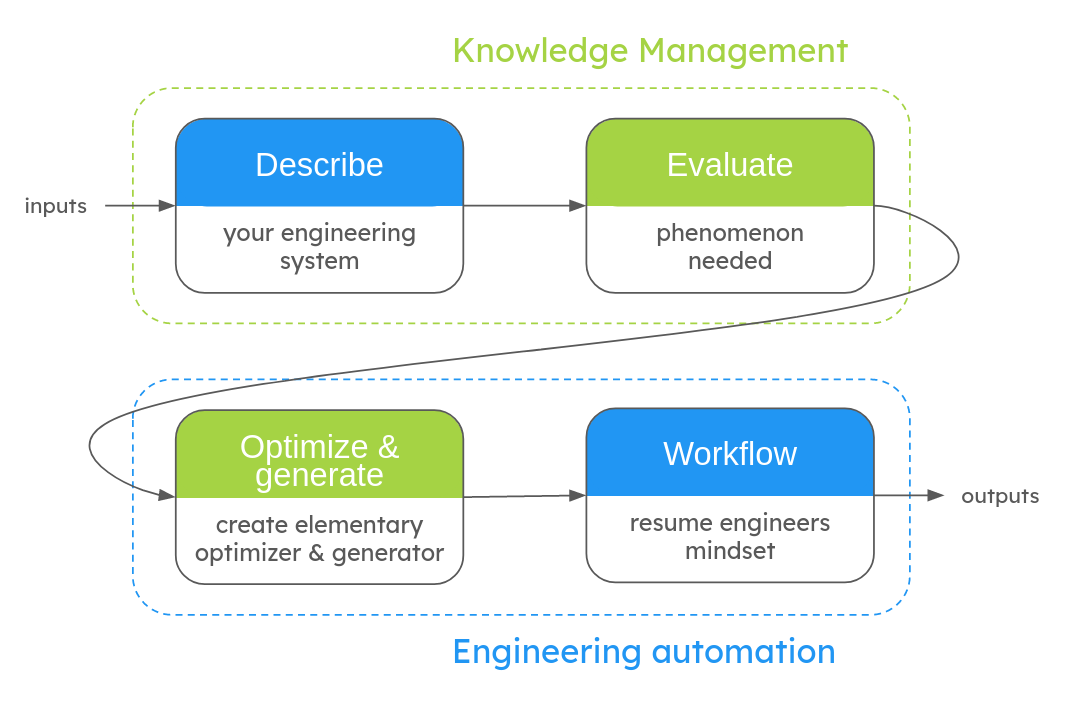

# Describe your engineering system


First of all, several python classes are written to define different objects that modelize the reductor along with all its components such as gears, shafts and motor.

Linking those objects is done by a Mesh class that represents the meshing between two gears.

All the classes presented in this part need to be coded in a same python file called core.py.

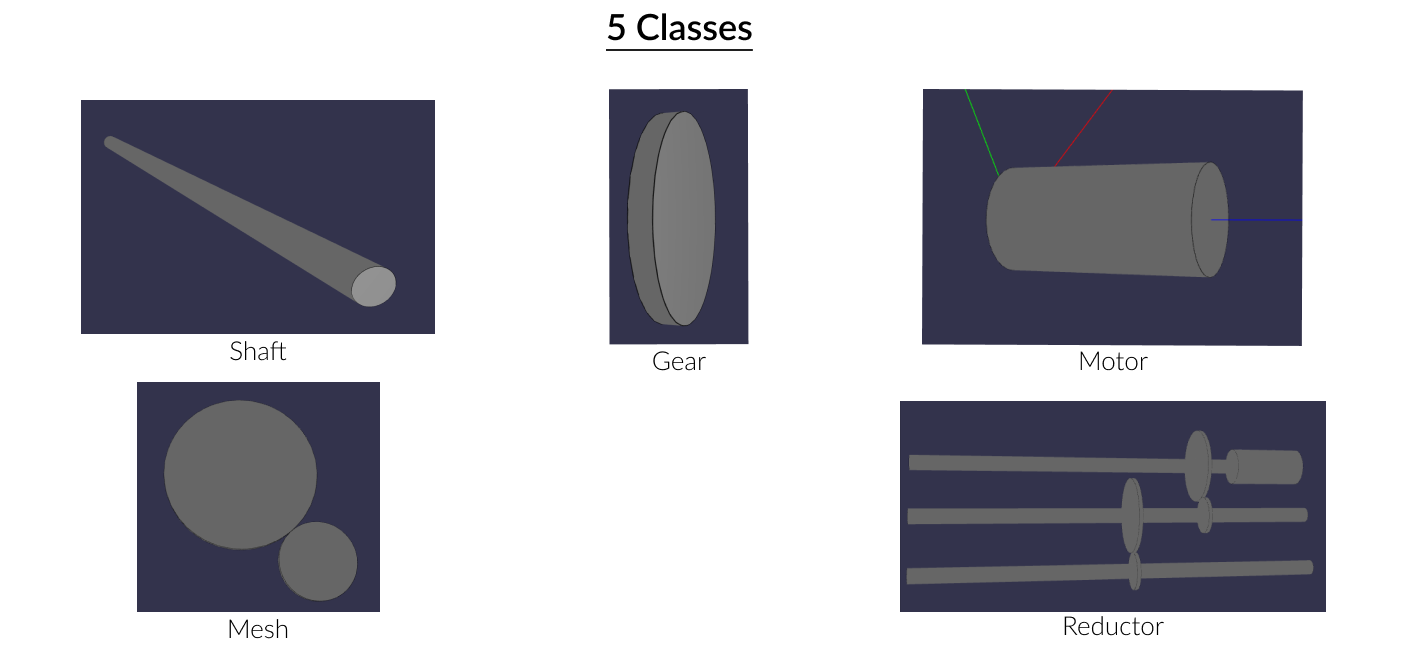

Let's begin with the easiest class which is the shaft. What are the parameters needed to initialize a shaft? In this example, there is the position (pos_x and pos_y), as well as the length and the name. Like all the other classes, the name is not an important argument, so we put the default value to " '' ". The z position is equal to self.length/2 because all the shafts have the same z position in this tutorial. Likewise, they have the same diameter (which is equal to 0.04 but can be changed).

In [4]:
class Shaft(PhysicalObject):

    def __init__(self, pos_x: float, pos_y: float, length: float, name: str=''):
        self.pos_x = pos_x
        self.pos_y = pos_y
        self.name = name
        self.length=length
        self.diameter=0.04
        self.z_position=self.length/2
        DessiaObject.__init__(self,name=name)

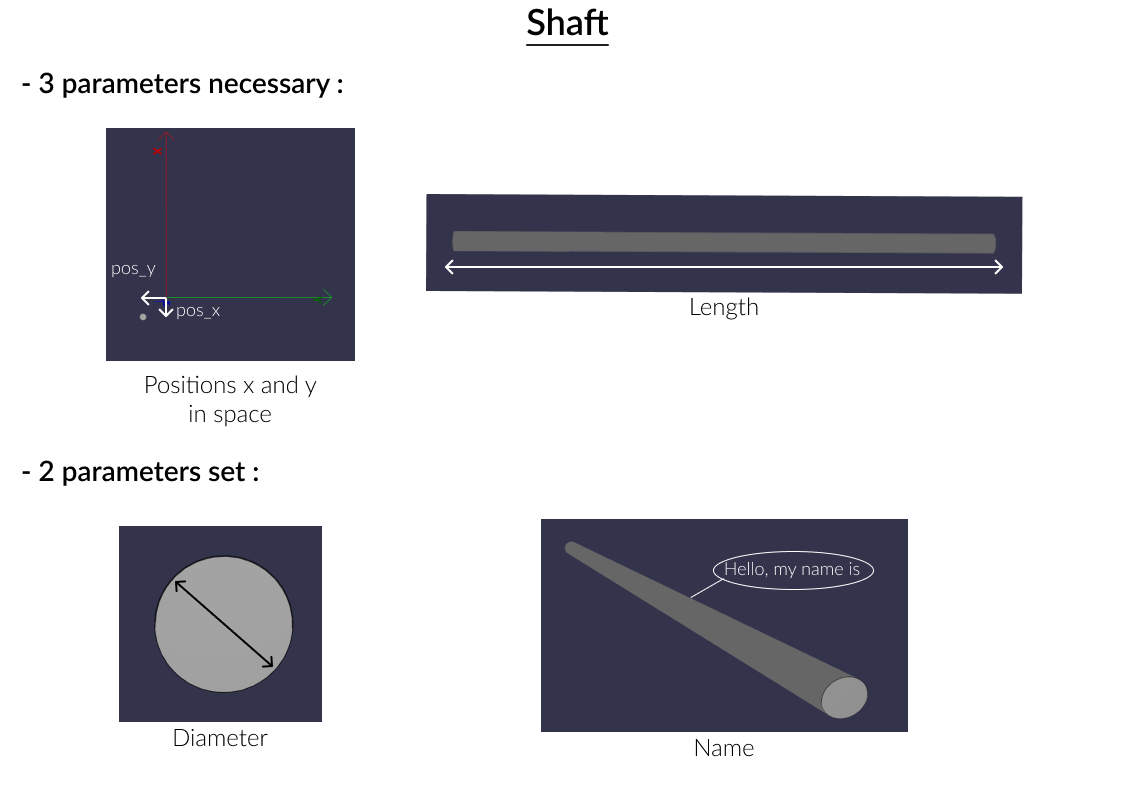

The Gear class modelizes one single gear and the diameter along with the length are needed for the initialization. In this tutorial, the number of teeth is not taken into account so the gear's diameter is used to calculate the ratio. The gear is directly linked to the shaft in its initialization through the "shaft" attribute. Another class could have been created in this situation, however that might not be relevant in this user-friendly case. The gear's position is the same as the shaft's (pos_x and pos_y). As for the z position, we consider a uniform distance to separate the shafts, called "offset" in the reductor class. The z_position parameter will store the future position of the gear. It is set to 0 for now.

In [5]:
class Gear(PhysicalObject):

    def __init__(self, diameter: float, length: float, shaft: Shaft, name: str=''):
        self.diameter = diameter
        self.length = length
        self.name = name
        self.shaft = shaft
        DessiaObject.__init__(self,name=name)
        self.z_position = 0

Now let's move on to the motor whose rotation speed is equal to the reductor's input speed. The parameters required for the initialization are the diameter, along with the length and the speed. As well as the gears, the positions will be given by the first shaft in the reductor. The x and y positions are set to 0. As for the z position, the motor is considered to be located at the first shaft's upstream (which always starts at the position 0 of the z axis), so we can set the value to self.length/2 (the position represents the motor's center).

In [6]:
class Motor(PhysicalObject):
    _standalone_in_db = True

    def __init__(self, diameter: float, length: float, speed: float, name: str = ''):
        self.diameter = diameter
        self.length = length
        self.speed = speed
        self.name = name
        DessiaObject.__init__(self,name=name)
        self.z_position=self.length/2
        self.pos_x=0
        self.pos_y=0

The Mesh represents the connections between two gears. It will connect the shafts in the reductor. Two gears and a name (this one is optional though) are required for the initialization. By the way, the two Gear arguments (gear1 and gear2) could have been replaced by one single list of Gear set as argument. The gears order is important for calculating the ratio. Here, gear1 is the driving gear and gear2 is the driven one.

In [7]:
class Mesh(DessiaObject):

    def __init__(self, gear1: Gear, gear2: Gear, name: str=''):
        self.gear1 = gear1
        self.gear2 = gear2
        self.gears = [gear1, gear2]
        self.name = name
        DessiaObject.__init__(self,name=name)

To finish, the Reductor class represents the reductor itself. A Motor, a list of Shaft, a list of Mesh and a name (optional) are required for the instantiation. In fact, the meshes already contain the gears, and the gears are already connected to the shafts. So we don't need to put the meshes in this initialization. The offset parameter is used to characterize the distance between the elements of the shafts.

In [8]:
class Reductor(PhysicalObject):
    _standalone_in_db = True

    def __init__(self, motor: Motor, shafts:List[Shaft], meshes: List[Mesh], name: str = ''):
        self.shafts = shafts
        self.meshes = meshes
        self.name = name
        self.motor = motor
        self.offset = 0.02
        DessiaObject.__init__(self,name=name)

# Define engineering simulations needed


## Volmdlr primitives

In this tutorial, most methods added to the classes are linked to the 3D representation (using volmdlr). Every component is represented by a cylinder towards z axis by using the position parameters. The volmdlr_primitives functions of the Shaft class , the Gear and the Motor are roughly the same.

In [9]:
def volmdlr_primitives(self):
    primitives = []
    pos = vm.Point3D(self.pos_x, self.pos_y, self.z_position)
    frame = vm.Frame3D(pos, vm.Z3D, vm.X3D, vm.Y3D)
    frame = vm.Frame3D(pos, vm.X3D, vm.Y3D, vm.Z3D)
    cylinder = p3d.Cylinder(frame, self.diameter/2, self.length)
    primitives.append(cylinder)
    return primitives

Shaft.volmdlr_primitives = volmdlr_primitives

In [10]:
def volmdlr_primitives(self):
    primitives = []
    pos = vm.Point3D(self.shaft.pos_x,self.shaft.pos_y, self.z_position)
    frame = vm.Frame3D(pos, vm.Z3D, vm.X3D, vm.Y3D)
    frame = vm.Frame3D(pos, vm.X3D, vm.Y3D, vm.Z3D)
    cylinder = p3d.Cylinder(frame, self.diameter/2, self.length)
    primitives.append(cylinder)
    return primitives

Gear.volmdlr_primitives = volmdlr_primitives

In [11]:
def volmdlr_primitives(self):
    primitives = []
    pos = vm.Point3D(self.pos_x, self.pos_y, self.z_position)
    frame = vm.Frame3D(pos, vm.Z3D, vm.X3D, vm.Y3D)
    frame = vm.Frame3D(pos, vm.X3D, vm.Y3D, vm.Z3D)
    cylinder = p3d.Cylinder(frame, self.diameter/2, self.length)
    primitives.append(cylinder)
    return primitives

Motor.volmdlr_primitives = volmdlr_primitives

The reductor case is a bit different as each one of its elements' z_position is needed. For that, we use the parameter offset and the length of the different elements. At first, we need to plot the motor by using the x and y positions of the first shaft. The z position is already set in the "init" of the motor to self.length/2. If the first shaft is located on z=0, there's no need to change.

Then, the program looks over the lists of gears and shafts, and plots them all using the right z_position. The order is important, which is why two loops are needed. One for gear1's first shaft meshes and one for gear1's second shaft meshes. Let's keep in mind that two gears of a same mesh have the same z_position. We also need to create a z_previous_position variable for the shaft and the gear to save the z position of the previous browsed element. The variable for the gear is initialized to self.motor.length + self.offset as we already plotted the motor. As for the shaft, the variable is initialized to 0 as the first shaft is located on z=0.

After that, in the for loop, half the current gear's length is added to z_previous_position to get the position of the current gear's center. Then, the z_position of the two gears has to be changed and their volmdlr_primitives functions must be called. Finally, as we're moving on to the next gear, z_previous_position_gear is refreshed and takes the current gear center's position.

The last part of the loop focuses on the shafts. Indeed, lengths and z_positions of every shaft have to be changed to prevent them from being disproportionate. We consider that the length of a shaft is equal to the distance between the two gears plus two offsets (on each extremity). As a result, considering the parameters of our system, the length of the shaft is equal to the z position of the previous gear + the length of the gear/2 + the offset - (the z position of the previous gear browsed - the length of the gear/2 - the offset). The part (the z position of the previous gear - the length of the gear/2 - the offset) is stored inside the variable z_previous_position_shaft. As for the z_position of the shaft, it's just the variable z_previous_position_shaft + the length of the shaft /2 . The case of the motor's first shaft is also considered by initializing the z_previous_position_shaft parameter to 0 so that the length of the shaft is equal to the length of the motor + the length of the gear+ 2 offset (there is no offset for the motor) and the z_position is equal to the length/2.

In [12]:
def volmdlr_primitives(self):
    primitives = []
    self.motor.pos_x = self.shafts[0].pos_x
    self.motor.pos_y = self.shafts[0].pos_y

    primitives.extend(self.motor.volmdlr_primitives())
    z_previous_position_gear = self.motor.length + self.offset
    z_previous_position_shaft = 0
    for shaft in self.shafts:
        for mesh in self.meshes:
            if mesh.gear1.shaft == shaft:
                z_position = z_previous_position_gear + mesh.gear1.length/2
                mesh.gear1.z_position = z_position
                mesh.gear2.z_position = z_position
                primitives.extend(mesh.gear1.volmdlr_primitives())
                primitives.extend(mesh.gear2.volmdlr_primitives())
                break

        shaft.length = z_position + mesh.gear1.length/2 + self.offset - z_previous_position_shaft
        shaft.z_position = shaft.length/2 + z_previous_position_shaft

        primitives.extend(shaft.volmdlr_primitives())

        z_previous_position_gear = z_position + mesh.gear2.length/2 + self.offset
        z_previous_position_shaft = z_position - mesh.gear2.length/2 - self.offset

    return primitives

Reductor.volmdlr_primitives = volmdlr_primitives

At this point, we finally managed to code our functions to get 3D representations. A couple functions are now added to calculate the mass of the different elements such as the gears, the shafts and the reductor. The mass is equal to the volume of the cylinder multiplied by the volumic mass (7500). The reductor's mass is calculated by adding the mass of each gear and each shaft.

## Calculation of the mass

In [13]:
def mass(self):
    return 7500*math.pi*self.length*(self.diameter/2)**2

Shaft.mass = mass

In [14]:
def mass(self):
    return 7500*math.pi*self.length*(self.diameter/2)**2

Gear.mass = mass

In [15]:
def mass(self):
    mass = 0
    for shaft in self.shafts:
        mass += shaft.mass()
    for meshe in self.meshes:
        for gear in [meshe.gear1, meshe.gear2]:
            mass += gear.mass()
    return mass

Reductor.mass = mass

## Computation of the speed output


To finish, the last function computes the output speed of the reductor. The idea is to go through the list of meshes and multiply the input speed by each ratio.

In [16]:
def speed_output(self):
    output_speed=self.motor.speed
    for mesh in self.meshes:
        output_speed = output_speed*mesh.gear1.diameter/mesh.gear2.diameter
    return output_speed

Reductor.speed_output = speed_output

# Create elementary generator & optimizer


## Create a class Optimizer

After coding all these classes and methods, we can make up our minds on how to optimize a reductor. First of all, let's add a new class called "Optimizer" in the core.py file. This class takes the reductor and every requirement the system is expected to meet as inputs. In our case, those are the speed_output and the box limitation. The box limitation is defined by the two tuples x_min_max and y_min_max.

## How to optimize?

The optimization is done by the "minimize" function imported from scipy.optimize. This function returns the arguments needed to minimize an objective function based on several criteria and conditions, using the gradient descend procedure. A good optimization relies on a "good" objective function. The closer to 0 the objective function, the better the optimization, the better the reductor meets its requirements. You can see the inputs and outputs of this function on this link (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

## Defining the x vector

The "minimize" function needs a x vector that specifies the parameters to optimize. In our tutorial, those are the x and y positions of every shaft and the diameter of one gear in all the meshes. The two gears are not needed as arguments as the diameter of the second gear is deduced from the first gear's diameter and the shaft. As a result, the vector x is composed of 8 elements, the 6 first are the positions x and y of the 3 shafts and the 2 last are the diameters of the 2 meshes' first gears.

## Defining the bounds of the optimization

We also have to create a "bounds" vector to bound (define min and max) of all the parameters of the x vector. In our case, the minimum and the maximum of the shaft's x and y positions are the parameters x_min_max and y_min_max. As for the two gears' diameters, the shaft's diameter is taken as the minimum and the diagonal of the box as the maximum. This bounds vector will be initialized in the "init" because we need it to use the "minimize" function but also to create an initialization vector.

In [17]:
class Optimizer(DessiaObject):
    _non_serializable_attributes = ['bounds']
    def __init__(self, reductor: Reductor, speed_output: float, x_min_max: Tuple[float, float], y_min_max: Tuple[float, float], name: str =''):
        self.reductor = reductor
        self.x_min_max = x_min_max
        self.y_min_max = y_min_max
        self.speed_output = speed_output
        DessiaObject.__init__(self,name=name)

        bounds = []
        for shaft in reductor.shafts:
            bounds.append([x_min_max[0], x_min_max[1]])
            bounds.append([y_min_max[0], y_min_max[1]])
        for mesh in reductor.meshes:
            bounds.append([mesh.gear1.shaft.diameter, ((y_min_max[1]-y_min_max[0])**2 + (x_min_max[1]-x_min_max[0])**2)**(1/2)])
        self.bounds = bounds

## How to choose and construct the initial conditions of an optimization?

The last parameter needed to use the "minimize" function is an initial x vector. This parameter is very important because the result of the optimization depends on it. Two optimizations can have different results if their initial vectors are different. A good pratice is to always create a function that builds the initial vector as settling the best one is sometimes tricky. This function calculates an "acceptable" initial vector from the random one by making it converging to an "acceptable" vector after each loop.

In this tutorial, the "random" function of numpy's "random" module is used. The command float(npy.random.random(1)) returns a random number between 0 and 1. We just have to multiply this random number by the difference between the min and the max of the bounds and add the minimum for all the bounds to construct our initialization vector.

In [18]:
def cond_init(self):
    x0 = []
    for interval in self.bounds:
        x0.append((interval[1]-interval[0])*float(npy.random.random(1))+interval[0])
    return x0

Optimizer.cond_init = cond_init

## Construct an update function in your objects

Now, let's build the objective function. The only rule is to set the x vector as its first input.

As for the function's body, the first thing to do is updating the reductor's parameters with the x vector. These parameters will change during the optimization. When a method from the reductor class is called, you have to make sure your object is up-to-date, ie is updated with the newest x vector.

This update function will be coded in the reductor class. The input of this function is the x vector, and we just have to assign the parameters of this vector to the right objects and arguments. The 6 first parameters are the x and y positions of the shafts, in their respective order. The 2 last are the meshes first gear's diameters, in their respective order too. The diameters of the other gears and meshes are deduced from their their centers' distances.

In [19]:
def update(self, x):
    i=0
    for shaft in self.shafts:
        shaft.pos_x=x[i]
        shaft.pos_y=x[i+1]
        i+=2
    for mesh in self.meshes:
        shaft_gear1=mesh.gear1.shaft
        shaft_gear2=mesh.gear2.shaft
        center_distance = ((shaft_gear1.pos_x-shaft_gear2.pos_x)**2+(shaft_gear1.pos_y-shaft_gear2.pos_y)**2)**(1/2)

        mesh.gear1.diameter = x[i]
        mesh.gear2.diameter = (center_distance-x[i]/2)*2
        i += 1

Reductor.update = update

## Build the objective function and add a speed specification in the optimization

Now, let's set up the specifications that the reductor is going to meet. Just as a reminder, the optimization is done when the objective function reaches a value near 0. So we just need to substract the current speed (calculated by the reductor's function) from the objective speed (the one in the Optimizer's init) and add the result to the parameter that objective function returns. In the tutorial, we call this parameter "functional", and this parameter must be always positive. If functional<0, the optimization fails.

Another thing that you can add to the condition check is a power/an exponent. The higher the power, the more important the slope of the function, the quicker the "minimize" function will find an optimized result. In this tutorial, we chose to add a power of 2 to the operations but this is something you can change.

In [20]:
def objective(self, x):
    self.reductor.update(x)
    speed = self.reductor.speed_output()
    functional = 0

    # Optimization of output speed
    functional += (self.speed_output- speed)**2

    return functional

Optimizer.objective = objective

## Construct an optimization into a function

For now, let's do a test using this condition in the objective function. Before that, we have to create an "optimize" function in the optimizer class that calls the "minimize" function but also the while loop with the initialization vector that we randomly choose (the function cond_init). This step, which consists in choosing the conditions, is a milestone that determines whether the optimization will be successful or not. The "success" output of the "minimize" function helps us know if the optimization encountered problems or not. Moreover, a "precision" parameter has to be set (which corresponds to the "fun" parameter of the resulting object). In our case there is only one specification, and we can say that an optimization is successful if the objective result is inferior to 1e-5 (the smaller the precision, the longer it takes to process the optimization).

Furthermore, a "max_loops" parameter is added, in case the precision is too small and the "success" is too hard to reach.

Finally, when an optimized result is found, the x vector has to be updated one last time. Otherwise, the current x vector might not be the finest one.

In [21]:
def optimize(self, max_loops=1000):
    valid = True
    count = 0
    while valid and count < max_loops:
        x0 = self.cond_init()
        self.reductor.update(x0)
        res = minimize(self.objective, x0, bounds=self.bounds)
        count += 1
        if  res.fun<1e-5 and res.success:
            self.reductor.update(res.x)
            valid = False
            return self.reductor
    return self.reductor

Optimizer.optimize = optimize

# Script

For the test, we have to code a script in another file called "scripts.py". In this file, you have to create a reductor object, use it to initialize an optimizer object and launch the optimize function. The diameters values are not important because they will change during the optimization. (We set it to 0 and 0.1). You can choose whatever you want as inputs of the motor and the specifications parameters of the optimizer.

In [22]:
def script_optimize():
    motor = Motor(diameter=0.1, length=0.2, speed=120)
    shafts = [Shaft(pos_x=0, pos_y=0, length=0.1), Shaft(pos_x=0, pos_y=0, length=0.1), Shaft(pos_x=0, pos_y=0, length=0.1)]
    meshes = []
    for j, shaft in enumerate(shafts) :
        if j == 1:
            gear1 = Gear(diameter=0.1, length=0.01, shaft=shaft)
            gear2 = Gear(diameter=0.1, length=0.01, shaft=shaft)
            meshes.append(Mesh(gear, gear1))
        else:
            gear = Gear(diameter=0.1, length=0.01, shaft=shaft)
    meshes.append(Mesh(gear2, gear))
    reductor = Reductor(motor, shafts, meshes)


    optimizer = Optimizer(reductor=reductor, speed_output=500, x_min_max=[-1,1], y_min_max=[-1,1])
    optimizer.optimize()
    return reductor


If you run this script, and use the function babylonjs on the reductor you will be shown a 3D representation.

In [23]:
reductor = script_optimize()

# Notebook usage
reductor.save_babylonjs_to_file(filename='/tmp/reductor3d')
HTML(filename='/tmp/reductor3d.html')

*Adding a position specification*

By calling the reductor's speed_output function, you can easily check that the speed condition is verified. However, you'll notice that the gears are way too big, which is not surprising since the box limits have not been set as specifications in the objective function.

In order to do that, we have to verify for each gears if their positions + their diameters/2 are inside the box. If a gear is outside of the box, we add the difference between the limit of the box and the position + the diameter/2 of the gear to the functional variable (raised to the power 2). We have to do that for all the borders of the box (one condition for each borders).

In [24]:
def objective(self, x):
    self.reductor.update(x)
    speed = self.reductor.speed_output()
    functional = 0

    # Optimization of output speed
    functional += (self.speed_output- speed)**2

    for mesh in self.reductor.meshes:
        for gear in [mesh.gear1,mesh.gear2]:

            # Optimization of surface
            if gear.shaft.pos_x-gear.diameter/2 < self.x_min_max[0]:
                functional += (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[0])**2

            if gear.shaft.pos_x+gear.diameter/2 > self.x_min_max[1]:
                functional+= (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[1])**2

            if gear.shaft.pos_y-gear.diameter/2 < self.y_min_max[0]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[0])**2

            if gear.shaft.pos_y+gear.diameter/2 > self.y_min_max[1]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[1])**2

    return functional

Optimizer.objective = objective

*Adding an optimization on the mass*

The box conditions are satisfied now, the last specification that we have to add is the mass optimization. For that, we just have to add the mass to the functional variable. However, this time we add a real parameter to the functional variable and not a difference. The mass parameter will never be equal to 0. The objective is to find the smallest value. Moreover, this parameter can interfere with the other specifications in the objective function. If this parameter is too high, the optimization will reduce this parameter without taking into account of the other conditions. But if this parameter is too small, the optimization might lack precision. As we are facing a dilemma, the specifications have to be sorted in the range of importance. In this tutorial, we chose to put the mass specification first, that's why we only added 1/10 of the mass to functional variable. You can try another distribution of importance between the specifications by dividing by another value.

In [25]:
def objective(self, x):
    self.reductor.update(x)
    speed = self.reductor.speed_output()
    functional = 0

    # Optimization of output speed
    functional += (self.speed_output- speed)**2

    for mesh in self.reductor.meshes:
        for gear in [mesh.gear1,mesh.gear2]:

            # Optimization of surface
            if gear.shaft.pos_x-gear.diameter/2 < self.x_min_max[0]:
                functional += (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[0])**2

            if gear.shaft.pos_x+gear.diameter/2 > self.x_min_max[1]:
                functional+= (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[1])**2

            if gear.shaft.pos_y-gear.diameter/2 < self.y_min_max[0]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[0])**2

            if gear.shaft.pos_y+gear.diameter/2 > self.y_min_max[1]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[1])**2

    # Optimization of mass
    functional += self.reductor.mass()/10

    return functional

Optimizer.objective = objective

Also, the precision might be changed to prevent the algorithm from taking too much time to run, since only 1/10 of the mass is added after each incrementation. Choosing the precision parameter might be difficult, which is why it will be determined by the computer through an algorithm that takes into account the specifications and the box limits.

In [26]:
def optimize(self, max_loops: int = 1000):
    valid = True
    count = 0
    while valid and count < max_loops:
        x0 = self.cond_init()
        self.reductor.update(x0)
        res = minimize(self.objective, x0, bounds=self.bounds)
        count += 1
        if res.fun < 10 and res.success:
            print(f'Solution found: count = {count}, cost function = {res.fun}')
            self.reductor.update(res.x)
            valid = False
            return self.reductor

    return self.reductor

Optimizer.optimize = optimize

If you run the script again, you will see that the size of the gear is smaller now.

In [27]:
reductor = script_optimize()

# Notebook usage
reductor.save_babylonjs_to_file(filename='/tmp/reductor3d')
HTML(filename='/tmp/reductor3d.html')

Solution found: count = 2, cost function = 0.337660203491701


*Other examples of adding a specification*

Now, all the specifications are met by the objective function. However, there are still some minor issues. For example, you can have the following type of problem where the diameter of the mesh's second gear is inferior to the diameter of the shaft:

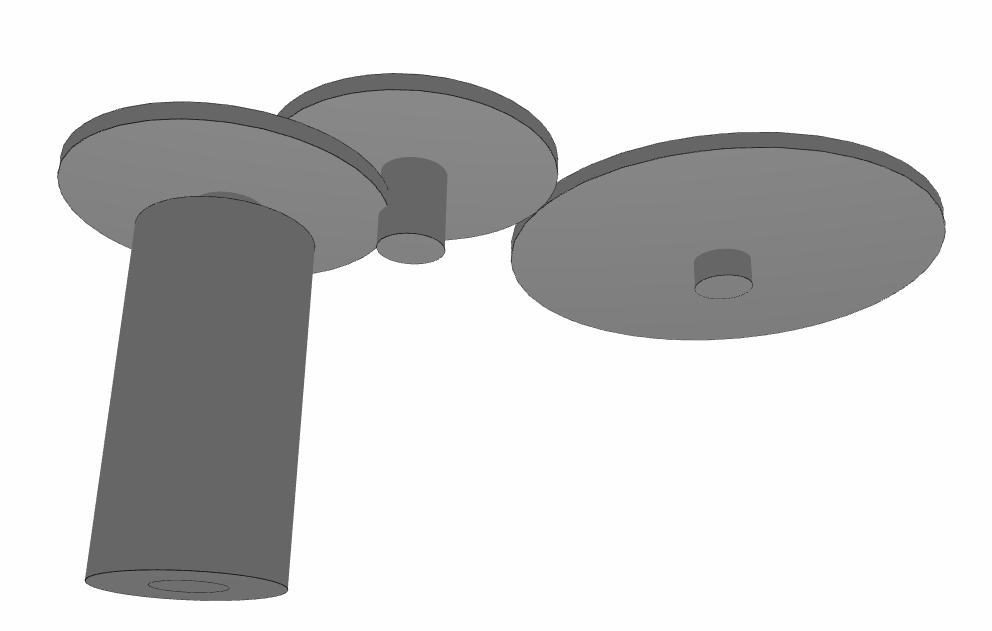

It's not a surprise as we have bounded the mesh first gear's diameter only. To solve this problem, we can add a condition in the objective function. In that case, it would not be a matter of reaching an objective, but something that the optimizer doesn't do. Thus, we can add a fixed value to the "functional" variable as long as the condition isn't verified, which is equal to 10 in our example. This will avoid the solutions from having this kind of issue.

In [28]:
def objective(self, x):
    self.reductor.update(x)
    speed = self.reductor.speed_output()
    functional = 0

    # Optimization of output speed
    functional += (self.speed_output- speed)**2
    for mesh in self.reductor.meshes:

        # Optimization of collisions
        if mesh.gear2.diameter<mesh.gear2.shaft.diameter:
              functional += 10

        for gear in [mesh.gear1,mesh.gear2]:
            # Optimization of surface
            if gear.shaft.pos_x-gear.diameter/2 < self.x_min_max[0]:
                functional += (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[0])**2

            if gear.shaft.pos_x+gear.diameter/2 > self.x_min_max[1]:
                functional+= (gear.shaft.pos_x-gear.diameter/2-self.x_min_max[1])**2

            if gear.shaft.pos_y-gear.diameter/2 < self.y_min_max[0]:
                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[0])**2

            if gear.shaft.pos_y+gear.diameter/2 > self.y_min_max[1]:

                functional += (gear.shaft.pos_y-gear.diameter/2-self.y_min_max[1])**2

    # Optimization of mass
    functional += self.reductor.mass()/10

    return functional

Optimizer.objective = objective

The optimizer is done now, but you can still go further and add some additional conditions to the objective function. For example, you can try to avoid collisions between shafts and gears. In our tutorial, the distance between shafts is set avoid collisions but changing lengths may create this kind of problems in some solutions:

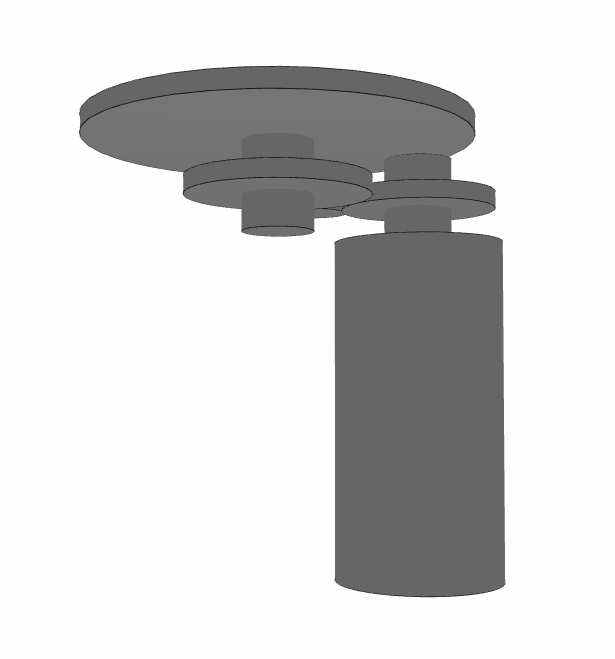

Provided that you deeply understood how the optimization works and how the objects are structured, that may be a good exercise. In addition, all the solutions will be collision-free.

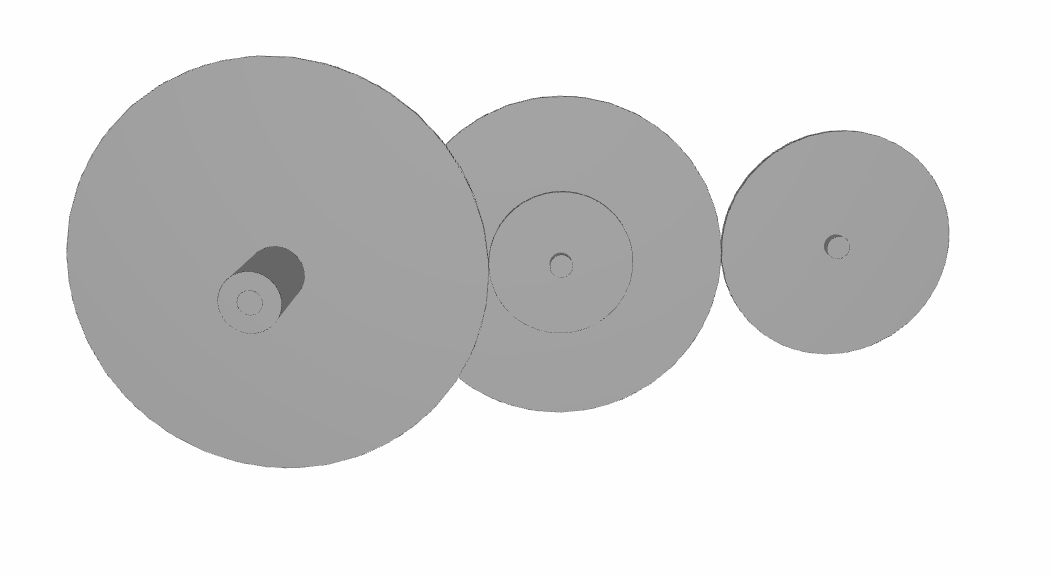

# Build your workflow

This is a preview of the workflow we are aiming to build in this section. This requires a few changes to facilitate the user experience when running the workflow. We will also create a more exhaustive optimizer, yielding several solutions, with better display settings.

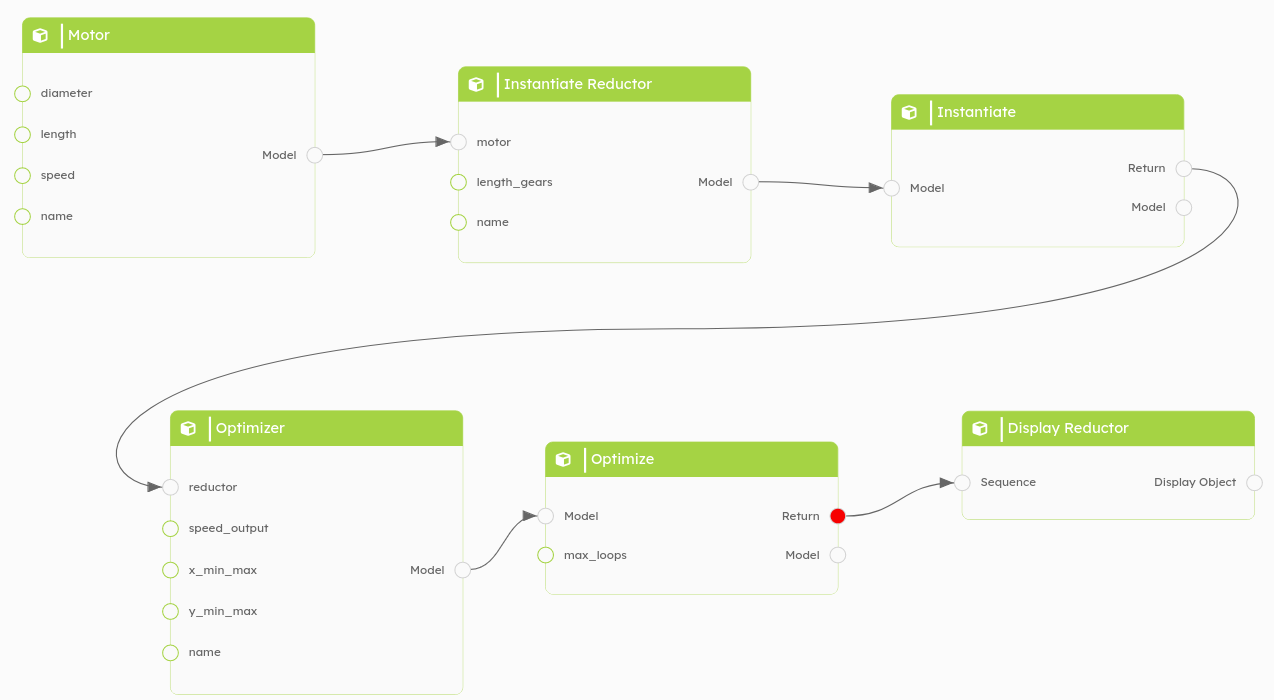


## Preparing the workflow creation

A reductor is needed for the optimization. However, instantiating all the gears and shafts is neither convenient, nor in the workflow's logic. Moreover, all the diameters and lengths are determined in the optimizer. Therefore, the only parameters that the user needs to choose are the motor and the optimizer's parameters as well as the length of the gears. Thus, a good way to overcome this problem to create an InstantiateReductor class that only needs a motor and a gear length to instantiate a reductor. Its "instantiate" method returns a reductor by automatically creating all the gears, meshes and shafts. This improvement makes the workflow much more user-friendly.

In [29]:
class InstantiateReductor(DessiaObject):

    def __init__(self, motor: Motor, length_gears: float = 0.01, name: str = ''):
        self.motor=motor

        self.length_gears=length_gears
        DessiaObject.__init__(self,name=name)


    def instantiate(self):
        shafts = [Shaft(pos_x=0, pos_y=0, length=0.1), Shaft(pos_x=0, pos_y=0, length=0.1),
                  Shaft(pos_x=0, pos_y=0, length=0.1)]
        meshes = []
        for j, shaft in enumerate(shafts) :
            if j == 1:
                gear1 = Gear(diameter=0.1, length=self.length_gears, shaft=shaft)
                gear2 = Gear(diameter=0.1, length=self.length_gears, shaft=shaft)
                meshes.append(Mesh(gear, gear1))
            else:
                gear = Gear(diameter=0.1, length=self.length_gears, shaft=shaft)
        meshes.append(Mesh(gear2, gear))
        reductor = Reductor(self.motor, shafts, meshes)
        return reductor

## Optimize more solutions

In this example, only one optimized solution is yielded. A few changes in the code are needed in order to compare the different optimizations. Firstly, we need to change the return of the optimize method. We remove the first return in the while loop and replace it by an add of a deep copy of the reductor in a list list_reductor, that we defined at the beginning of the method. The last return will now return the list_reductor and not just the reductor. The optimize function return now a list of solutions optimized.

In [30]:
def optimize(self, max_loops: int = 1000):
    valid = True
    count = 0
    list_reductor = []
    while valid and count < max_loops:
        x0 = self.cond_init()
        self.reductor.update(x0)
        res = minimize(self.objective, x0, bounds=self.bounds)
        count += 1
        if  res.fun < 10 and res.success:
            print(f'Solution found: count = {count}, cost function = {res.fun}')
            self.reductor.update(res.x)
            list_reductor.append(copy.deepcopy(self.reductor))
    return list_reductor

Optimizer.optimize = optimize

## Add parameters to compare the results of an optimization

Secondly, a few parameters are needed to compare these solutions. This may be the mass, which has already been calculated. But it needs to be declared as the Reductor class' attribute. That's why a new "mass" attribute is introduced. It stores the `mass()` method's output. This parameter has to get updated when using the optimizer.

In [31]:
def __init__(self, motor: Motor, shafts: List[Shaft], meshes: List[Mesh], name: str = ''):
    self.shafts = shafts
    self.meshes = meshes
    self.name = name
    self.motor = motor
    self.offset = 0.02
    DessiaObject.__init__(self,name=name)
    self.mass = self.mass()

Reductor.__init__ = __init__

def update(self, x):
    i=0
    for shaft in self.shafts:
        shaft.pos_x = x[i]
        shaft.pos_y = x[i+1]
        i+=2
    for mesh in self.meshes:
        shaft_gear1=mesh.gear1.shaft
        shaft_gear2=mesh.gear2.shaft
        center_distance = ((shaft_gear1.pos_x-shaft_gear2.pos_x) ** 2
                           + (shaft_gear1.pos_y-shaft_gear2.pos_y) ** 2) ** 0.5

        mesh.gear1.diameter = x[i]
        mesh.gear2.diameter = (center_distance-x[i]/2)*2
        i += 1
    self.mass = self.mass()

Reductor.update = update

At your convenience, you can add other parameters to compare these solutions. Another parameter that we add is number_solution, equal to the position of the reductor in list_reductor. That will help have a good plot of the solutions in the ParallelPlot display. To do so, we add the attribute to init and update it in the optimize method.

The number of displayed solutions may also be an interesting parameter as it prevents the plot from displaying too much solutions. Let's define a parameter named "number_solution" and add it to the "optimize" function.

In [32]:
def __init__(self, motor: Motor, shafts: List[Shaft], meshes: List[Mesh], number_solution: int = 0,name: str = ''):
    self.shafts = shafts
    self.meshes = meshes
    self.name = name
    self.motor = motor
    self.offset = 0.02
    DessiaObject.__init__(self,name=name)
    self.mass = self.mass()
    self.number_solution = number_solution

Reductor.__init__ = __init__

def optimize(self, max_loops: int = 1000):
    valid = True
    count = 0
    list_reductor = []
    while valid and count < max_loops:
        x0 = self.cond_init()
        self.reductor.update(x0)
        res = minimize(self.objective, x0, bounds=self.bounds)
        count += 1
        if  res.fun < 10 and res.success:
            print(f'Solution found: count = {count}, cost function = {res.fun}')
            self.reductor.update(res.x)
            self.reductor.number_solution = len(list_reductor)
            list_reductor.append(copy.deepcopy(self.reductor))
    return list_reductor

Optimizer.optimize = optimize

## Create a workflow for an optimization

This part is about building a good workflow from the optimizer. To so, connect to your Dessia platform and upload your package as an application. Then, head to *Bot Store* and click *New Bot*. From there, you will be given an empty canvas on which you can place your blocks. On the left-hand side panel, you can add blocks and pipes. The workflow is composed of :


*   A block Motor : an *InstantiateModel* block of a `Motor` model class
*   A block Instantiate Reductor : an *InstantiateModel* block of a `InstantiateReductor` model class
*   A block Instantiate : a *ModelMethod* block of the method `InstantiateReductor.instantiate`
*   A block Optimizer : an *InstantiateModel* block of a `Optimizer` model class
*   A block Optimize : a *ModelMethod* block of the method `Optimizer.optimize`
*   A block Display Reductor : a *MultiPlot* block displaying the attributes `mass_reductor` and `number_solution`



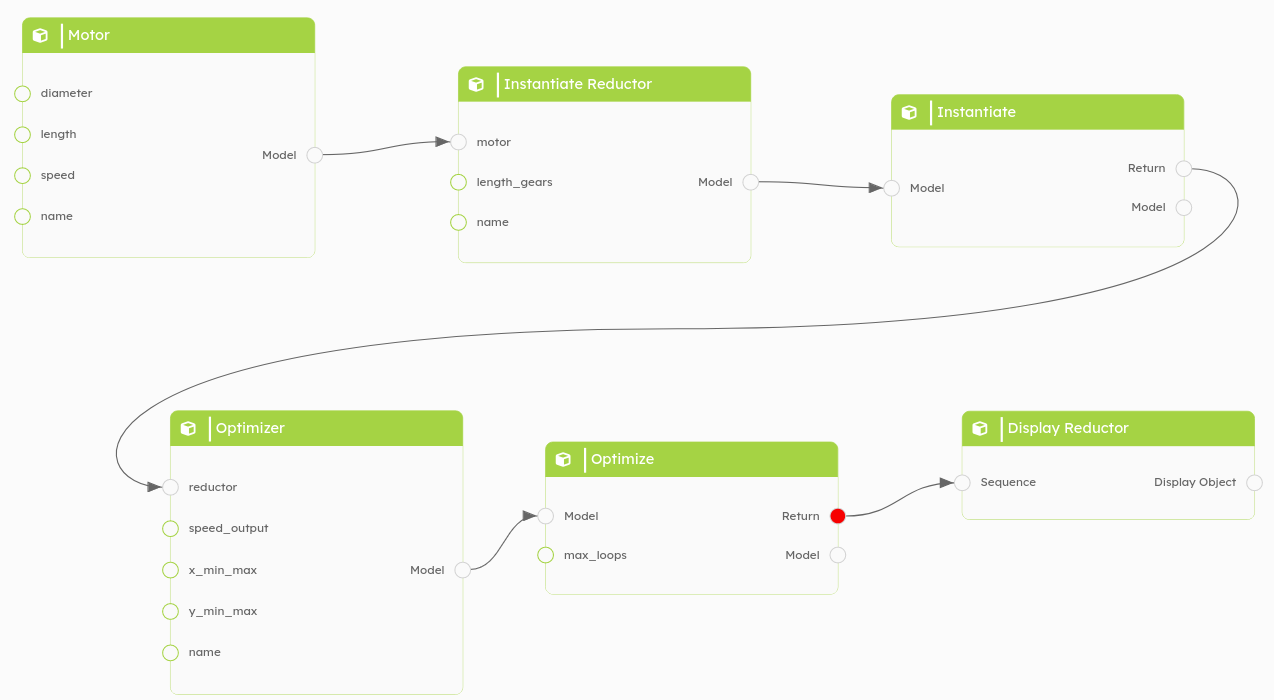

This tutorial now comes to an end, and you should have all the capacities to created your future bot.